# EXERCISE 2:

Consider the dataset WorldMarkts99 20.RDS containing price history from 1999- 01-01 to 2020-04-30 of 11 market indices worldwide plus VLIC and VIX. The script HW1 markets.R will help you retrieve data (optionally) and organise it for the rest of this exercise. For the epoch assigned to your team in the Google spreadsheet, the corresponding team must do: A full causality analysis for the first four lags of the returns time series of these 11 market indices, and a full causality analysis for the first four lags of the volatilities series of these market return indices (this is known as volatility spill-over).
Do this analysis sampling the series first weekly and then monthly periods. Estimate volatility using EMA (see Prob. 1). Tabulate and comment your results (four tables, one for returns, other for volatility and each for weekly and for monthly sampling), so that cause → effect goes from row to column, and each entry a 4-vector of {0, 1} indicating causality (1) or not (0) for each lag (coordinate). Example
India Brazil UK . . . USA (1,0,1,1) (0,1,1,0) (1,1,1,0) ... Brazil (0,0,1,1) (1,0,0,0) ...
. . . . .
so, first entry means US → India at lags 1,3,4.
Causality should be considered significant at the 5% level. Comment your results. Among which countries there is true causality, or contemporaneous correlation? Can you device a network of causalities?


# INDEX:

0. [DATA AND LIBRARY IMPORTS](#0.-DATA-AND-LIBRARY-IMPORTS)

1. [TIMEFRAME TRANSFORMATION](#1.-TIMEFRAME-TRANSFORMATION)

2. [FEATURE CREATION](#2.-FEATURE-CREATION)

3. [STATIONARITY CHECK](#3.-STATIONARITY-CHECK)

4. [CAUSALITY ANALYSIS](#4.-CAUSALITY-ANALYSIS)

# 0. DATA AND LIBRARY IMPORTS

[Back to Index](#INDEX)

In [838]:
import pandas as pd 
import numpy as np
import pyreadr
import os
import warnings

# Suppress specific FutureWarnings from statsmodels
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [839]:
all_market_data = {}

for file in os.listdir('data'):
    file_name = 'data/' + file
    key_name = file.split('.')[0]
    all_market_data[key_name] = pd.read_csv(file_name, index_col=0)

print(all_market_data.keys())

dict_keys(['HSCE', 'VLIC', 'MXX', 'N225', 'BVSP', 'GSPC', 'JKSE', 'IBEX', 'VIX', 'BSESN', 'GDAXI', 'FTSE', 'TWII'])


treat outliers and missing data

In [840]:
# find outliers with iqr
def remove_outliers(data):
    for col in data.columns:
        threshold = 2

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # replace outliers with NA
        data.loc[(data[col] < (Q1 - threshold * IQR)) | (data[col] > (Q3 + threshold * IQR)), col] = np.nan
    return data 

In [841]:

for key in all_market_data.keys(): 
    all_market_data[key].columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    all_market_data[key] = remove_outliers(all_market_data[key])
    ffill = all_market_data[key].ffill()
    bfill = all_market_data[key].bfill()
    all_market_data[key] = ffill+bfill / 2
    all_market_data[key]['Returns'] = all_market_data[key]['Adj Close'].pct_change()
    all_market_data[key] = all_market_data[key][1:-1]
    # the last value for market volume for BVSP was missing so we filled it with 0
    all_market_data[key] = all_market_data[key].fillna(0)


In [842]:
for each in all_market_data.keys():
    print(all_market_data[each].isna().sum().sum())   
    print(all_market_data[each].shape)
    # print max and min index
    print(all_market_data[each].index.min())
    print(all_market_data[each].index.max())

0
(5348, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5427, 7)
1999-01-05
2020-04-28
0
(5364, 7)
1999-01-05
2020-04-28
0
(5373, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5372, 7)
1999-01-05
2020-04-28
0
(5482, 7)
1999-01-05
2020-04-28
0
(5363, 7)
1999-01-05
2020-04-28
0
(5346, 7)
1999-01-05
2020-04-28
0
(5457, 7)
1999-01-05
2020-04-28
0
(5444, 7)
1999-01-05
2020-04-28
0
(5350, 7)
1999-01-06
2020-04-28


In [843]:
# plot the returns of all of the markets in plotly express
import plotly.express as px

fig = px.line()
for key in all_market_data.keys():    
    fig.add_scatter(x=all_market_data[key].index, y=all_market_data[key]['Returns'], mode='lines', name=key)
fig.show()

In [844]:
df = pd.concat(all_market_data, keys=all_market_data.keys(), names=['Market', 'Date'])
df.head()


Open         High          Low        Close  Volume  \
Market Date                                                                     
HSCE   1999-01-05  2524.109985  2540.655030  2493.884949  2494.545044     0.0   
       1999-01-06  2493.375000  2610.090089  2493.375000  2610.090089     0.0   
       1999-01-07  2634.975036  2689.034911  2628.854919  2645.399964     0.0   
       1999-01-08  2647.679993  2657.445007  2594.850036  2608.005066     0.0   
       1999-01-11  2607.479919  2612.505066  2510.234985  2514.210022     0.0   

                     Adj Close   Returns  
Market Date                               
HSCE   1999-01-05  2494.545044 -0.012681  
       1999-01-06  2610.090089  0.046319  
       1999-01-07  2645.399964  0.013528  
       1999-01-08  2608.005066 -0.014136  
       1999-01-11  2514.210022 -0.035964

In [845]:
# Reset index without dropping the current index
df.reset_index(drop=False, inplace=True)
df.head()



Market        Date         Open         High          Low        Close  \
0   HSCE  1999-01-05  2524.109985  2540.655030  2493.884949  2494.545044   
1   HSCE  1999-01-06  2493.375000  2610.090089  2493.375000  2610.090089   
2   HSCE  1999-01-07  2634.975036  2689.034911  2628.854919  2645.399964   
3   HSCE  1999-01-08  2647.679993  2657.445007  2594.850036  2608.005066   
4   HSCE  1999-01-11  2607.479919  2612.505066  2510.234985  2514.210022   

   Volume    Adj Close   Returns  
0     0.0  2494.545044 -0.012681  
1     0.0  2610.090089  0.046319  
2     0.0  2645.399964  0.013528  
3     0.0  2608.005066 -0.014136  
4     0.0  2514.210022 -0.035964

In [846]:
# Filter the DataFrame based on the date range
df = df[(df['Date'] >= '2000-01') & (df['Date'] <= '2002-12')]

# Display the filtered DataFrame
df.head()

Market        Date         Open         High          Low        Close  \
259   HSCE  2000-01-03  2965.335022  3021.479919  2965.335022  2999.984985   
260   HSCE  2000-01-04  2998.170044  3171.750000  2995.229919  3124.394898   
261   HSCE  2000-01-05  3103.680175  3103.680175  2864.250000  2934.854919   
262   HSCE  2000-01-06  2938.634949  2962.020081  2786.354919  2856.299926   
263   HSCE  2000-01-07  2858.520081  3035.039978  2858.520081  3006.765015   

     Volume    Adj Close   Returns  
259     0.0  2999.984985  0.009218  
260     0.0  3124.394898  0.041470  
261     0.0  2934.854919 -0.060665  
262     0.0  2856.299926 -0.026766  
263     0.0  3006.765015  0.052678

In [847]:
df.set_index(['Market', 'Date'], inplace=True)


In [848]:
df.index

MultiIndex([('HSCE', '2000-01-03'),
            ('HSCE', '2000-01-04'),
            ('HSCE', '2000-01-05'),
            ('HSCE', '2000-01-06'),
            ('HSCE', '2000-01-07'),
            ('HSCE', '2000-01-10'),
            ('HSCE', '2000-01-11'),
            ('HSCE', '2000-01-12'),
            ('HSCE', '2000-01-13'),
            ('HSCE', '2000-01-14'),
            ...
            ('TWII', '2002-11-18'),
            ('TWII', '2002-11-19'),
            ('TWII', '2002-11-20'),
            ('TWII', '2002-11-21'),
            ('TWII', '2002-11-22'),
            ('TWII', '2002-11-25'),
            ('TWII', '2002-11-26'),
            ('TWII', '2002-11-27'),
            ('TWII', '2002-11-28'),
            ('TWII', '2002-11-29')],
           names=['Market', 'Date'], length=9793)

# 1. TIMEFRAME TRANSFORMATION

## IMPORTANT: I AM AGGREGRATING MEAN THE TIMEFRAME FOR RETURN AND STD FOR VOLATILITY

In [849]:
import pandas as pd

# Assuming 'df' is your DataFrame and it has a MultiIndex with levels 'Market' and 'Date'

# Convert the 'Date' part of the MultiIndex to datetime if it isn't already
df.index = pd.MultiIndex.from_arrays(
    [df.index.get_level_values('Market'), pd.to_datetime(df.index.get_level_values('Date'))]
)

# Define the aggregation rules
agg_rules = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'mean',
    'Adj Close': 'last',
    'Returns': ['last', 'std', 'mean']
}

# Function to resample, aggregate, and rename data at the market level
def resample_and_aggregate(data, freq):
    # Group by Market and resample by Date at the specified frequency
    aggregated_data = data.groupby(level='Market').resample(freq, level='Date').agg(agg_rules)

    # Renaming the columns for clarity
    aggregated_data.columns = [' '.join(col).strip() for col in aggregated_data.columns.values]
    rename_dict = {
        'Returns last': 'Returns Last',
        'Returns mean': 'Returns Mean',
        'Returns std': 'Returns Volatility'
    }
    # Update column names with more descriptive names
    aggregated_data.rename(columns=rename_dict, inplace=True)
    
    return aggregated_data

# Aggregate by week and month
weekly_df = resample_and_aggregate(df, 'W')
monthly_df = resample_and_aggregate(df, 'M')

# Output the results (you can modify this to output or save data as needed)
print("Weekly Aggregated Data:")
print(weekly_df.head())

print("\nMonthly Aggregated Data:")
print(monthly_df.head())




Weekly Aggregated Data:
                    Open first     High max      Low min   Close last  \
Market Date                                                             
BSESN  2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
       2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
       2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
       2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
       2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   

                   Volume mean  Adj Close last  Returns Last  \
Market Date                                                    
BSESN  2000-01-09          0.0     8121.719970     -0.001300   
       2000-01-16          0.0     8206.905030      0.004858   
       2000-01-23          0.0     8134.574707      0.012556   
       2000-01-30          0.0     8003.699707     -0.006202   
       2000-02-06          0.0     7970.384766     -0.004981   

               

In [850]:
monthly_df

Open first     High max      Low min   Close last  \
Market Date                                                             
BSESN  2000-01-31  7814.310059  8502.419678  7776.719970  7807.935059   
       2000-02-29  7826.474853  9226.034911  7691.685059  8171.205322   
       2000-03-31  8196.974853  8743.185059  7300.844970  7501.919678   
       2000-04-30  7605.750000  8314.215089  6426.254883  6986.324707   
       2000-05-31  7135.900147  7136.835206  5747.790160  6650.414794   
...                        ...          ...          ...          ...   
VLIC   2002-07-31   486.464997   486.464997   373.860007   417.449982   
       2002-08-31   417.449982   437.880020   384.480010   414.195007   
       2002-09-30   414.195007   418.380020   359.474991   366.974991   
       2002-10-31   366.974991   389.490006   326.519990   383.910003   
       2002-11-30   383.910003   424.890015   379.290002   421.634994   

                    Volume mean  Adj Close last  Returns Last  \
Market Date                                                     
BSESN  2000-01-31  0.000000e+00     7807.935059     -0.024459   
       2000-02-29  0.000000e+00     8171.205322     -0.051077   
       2000-03-31  0.000000e+00     7501.919678     -0.007895   
       2000-04-30  0.000000e+00     6986.324707     -0.004718   
       2000-05-31  0.000000e+00     6650.414794      0.028258   
...                         ...             ...           ...   
VLIC   2002-07-31  1.606364e+07      417.449982     -0.011649   
       2002-08-31  1.228295e+07      414.195007     -0.004471   
       2002-09-30  1.214100e+07      366.974991     -0.008872   
       2002-10-31  1.516043e+07      383.910003     -0.000625   
       2002-11-30  1.680150e+07      421.634994     -0.003969   

                   Returns Volatility  Returns Mean  
Market Date                                          
BSESN  2000-01-31            0.021003      0.000913  
       2000-02-29            0.024254      0.002451  
       2000-03-31            0.018175     -0.003550  
       2000-04-30            0.032307     -0.003057  
       2000-05-31            0.029217     -0.001730  
...                               ...           ...  
VLIC   2002-07-31            0.024207     -0.006662  
       2002-08-31            0.020103     -0.000163  
       2002-09-30            0.018351     -0.005873  
       2002-10-31            0.024246      0.002244  
       2002-11-30            0.017811      0.004848  

[455 rows x 9 columns]

In [851]:
weekly_df

Open first     High max      Low min   Close last  \
Market Date                                                             
BSESN  2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
       2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
       2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
       2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
       2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   
...                        ...          ...          ...          ...   
VLIC   2002-11-03   385.814987   393.509994   373.530006   393.509994   
       2002-11-10   393.509994   405.644990   389.009994   389.865006   
       2002-11-17   389.865006   398.789977   379.290002   398.445007   
       2002-11-24   398.445007   416.279984   392.070007   414.390015   
       2002-12-01   414.390015   424.890015   410.384994   421.634994   

                   Volume mean  Adj Close last  Returns Last  \
Market Date                                                    
BSESN  2000-01-09          0.0     8121.719970     -0.001300   
       2000-01-16          0.0     8206.905030      0.004858   
       2000-01-23          0.0     8134.574707      0.012556   
       2000-01-30          0.0     8003.699707     -0.006202   
       2000-02-06          0.0     7970.384766     -0.004981   
...                        ...             ...           ...   
VLIC   2002-11-03   14511000.0      393.509994      0.025006   
       2002-11-10   14289000.0      389.865006     -0.014447   
       2002-11-17   14202000.0      398.445007      0.005527   
       2002-11-24   21141000.0      414.390015      0.004107   
       2002-12-01   18176250.0      421.634994     -0.003969   

                   Returns Volatility  Returns Mean  
Market Date                                          
BSESN  2000-01-09            0.026863      0.011181  
       2000-01-16            0.029187      0.002431  
       2000-01-23            0.015210     -0.001676  
       2000-01-30            0.008693     -0.003208  
       2000-02-06            0.015509     -0.000737  
...                               ...           ...  
VLIC   2002-11-03            0.014885      0.004045  
       2002-11-10            0.018049     -0.001729  
       2002-11-17            0.020451      0.004531  
       2002-11-24            0.016238      0.007983  
       2002-12-01            0.021006      0.004507  

[1976 rows x 9 columns]

# 2. FEATURE CREATION

In [852]:
# Rename 'Returns Mean' to 'Returns_Mean_Weekly' for the weekly data
weekly_df.rename(columns={'Returns Mean': 'Returns_Mean_Weekly'}, inplace=True)

# Rename 'Returns Mean' to 'Returns_Mean_Monthly' for the monthly data
monthly_df.rename(columns={'Returns Mean': 'Returns_Mean_Monthly'}, inplace=True)

In [853]:
import pandas as pd

# Define the span for the EMA calculation
span = 4  # Adjust based on analysis needs

# Calculate EMA for Weekly Returns Volatility using transform()
weekly_df['EMA_Weekly_Volatility'] = weekly_df.groupby(level='Market')['Returns Volatility'].transform(lambda x: x.ewm(span=span, adjust=False).mean())

# Calculate EMA for Monthly Returns Volatility using transform()
monthly_df['EMA_Monthly_Volatility'] = monthly_df.groupby(level='Market')['Returns Volatility'].transform(lambda x: x.ewm(span=span, adjust=False).mean())

# Print some of the results to verify
print("Weekly EMA Volatility:")
print(weekly_df[['EMA_Weekly_Volatility']].head())
print("\nMonthly EMA Volatility:")
print(monthly_df[['EMA_Monthly_Volatility']].head())



Weekly EMA Volatility:
                   EMA_Weekly_Volatility
Market Date                             
BSESN  2000-01-09               0.026863
       2000-01-16               0.027792
       2000-01-23               0.022760
       2000-01-30               0.017133
       2000-02-06               0.016483

Monthly EMA Volatility:
                   EMA_Monthly_Volatility
Market Date                              
BSESN  2000-01-31                0.021003
       2000-02-29                0.022303
       2000-03-31                0.020652
       2000-04-30                0.025314
       2000-05-31                0.026875


# 3. STATIONARITY ANALYSIS

# Weekly Stationarity

Observations on Stationarity from the Weekly Plots:
BSESN, BVSP, FTSE, GDAXI, GSPC, HSCE, IBEX, JKSE, MXX, N225, TWII, VIX, VLIC (Returns)
- Trend: Most return series seem to hover around a mean level, without obvious trends or persistent drifts in one direction, which suggests they might be stationary in mean.
- Seasonality: There does not appear to be any clear seasonality affecting these returns.
- Variance: The variance (width of fluctuations) seems to be relatively constant in some markets like BSESN, GSPC, and IBEX, suggesting potential stationarity. However, others, like FTSE and VIX, show periods of high volatility, particularly noticeable during specific intervals which might indicate non-stationarity.
- Volatility Clusters: Several markets exhibit periods of high volatility (larger swings in returns), particularly evident in the VIX and GDAXI, which could suggest non-stationarity as the variance is not consistent over time.

BSESN, BVSP, FTSE, GDAXI, GSPC, HSCE, IBEX, JKSE, MXX, N225, TWII, VIX, VLIC (Volatility)
- Trend and Mean: The volatility, measured as EMA of weekly volatility, generally shows no long-term trend but has different levels at different times.
- Variance and Volatility: The volatility of volatility (meta-volatility) seems consistent in some markets but not in others. Markets like VIX, which naturally measure market volatility, show larger spikes and more evident periods of increased activity, likely indicating non-stationary behavior.

Observations on Stationarity from the Monthly Plots:

Returns for BSESN, BVSP, FTSE, GDAXI, GSPC, HSCE, IBEX, JKSE, MXX, N225, TWII, VIX, VLIC:
- Trend: The returns for many markets such as BSESN, GDAXI, and GSPC do not display strong or obvious trends, which might suggest potential stationarity in mean. However, some markets like N225 and TWII show slight but discernible upward or fluctuating trends, which could hint at non-stationarity.
- Seasonality: There are no evident seasonal patterns that can be discerned from the visual data, indicating a lack of clear seasonality affecting these returns.
- Variance:The variance in returns across the majority of the markets appears relatively stable, suggesting possible stationarity. Markets like GSPC and IBEX maintain a consistent range of fluctuation. However, markets such as FTSE and VIX exhibit occasional periods of increased variance, especially noticeable during financial turmoil or market adjustments, pointing to possible non-stationarity.
- Volatility Clustes: Notable markets such as VIX, which is expected to be volatile, and GDAXI show periods of heightened volatility. This inconsistency in variance over time might suggest non-stationarity.

Volatility for BSESN, BVSP, FTSE, GDAXI, GSPC, HSCE, IBEX, JKSE, MXX, N225, TWII, VIX, VLIC:
- Trend and Mean: The EMA of monthly volatility generally shows smooth trends with varying levels at different times across most markets, hinting at potential non-stationarity due to these changes in volatility levels.

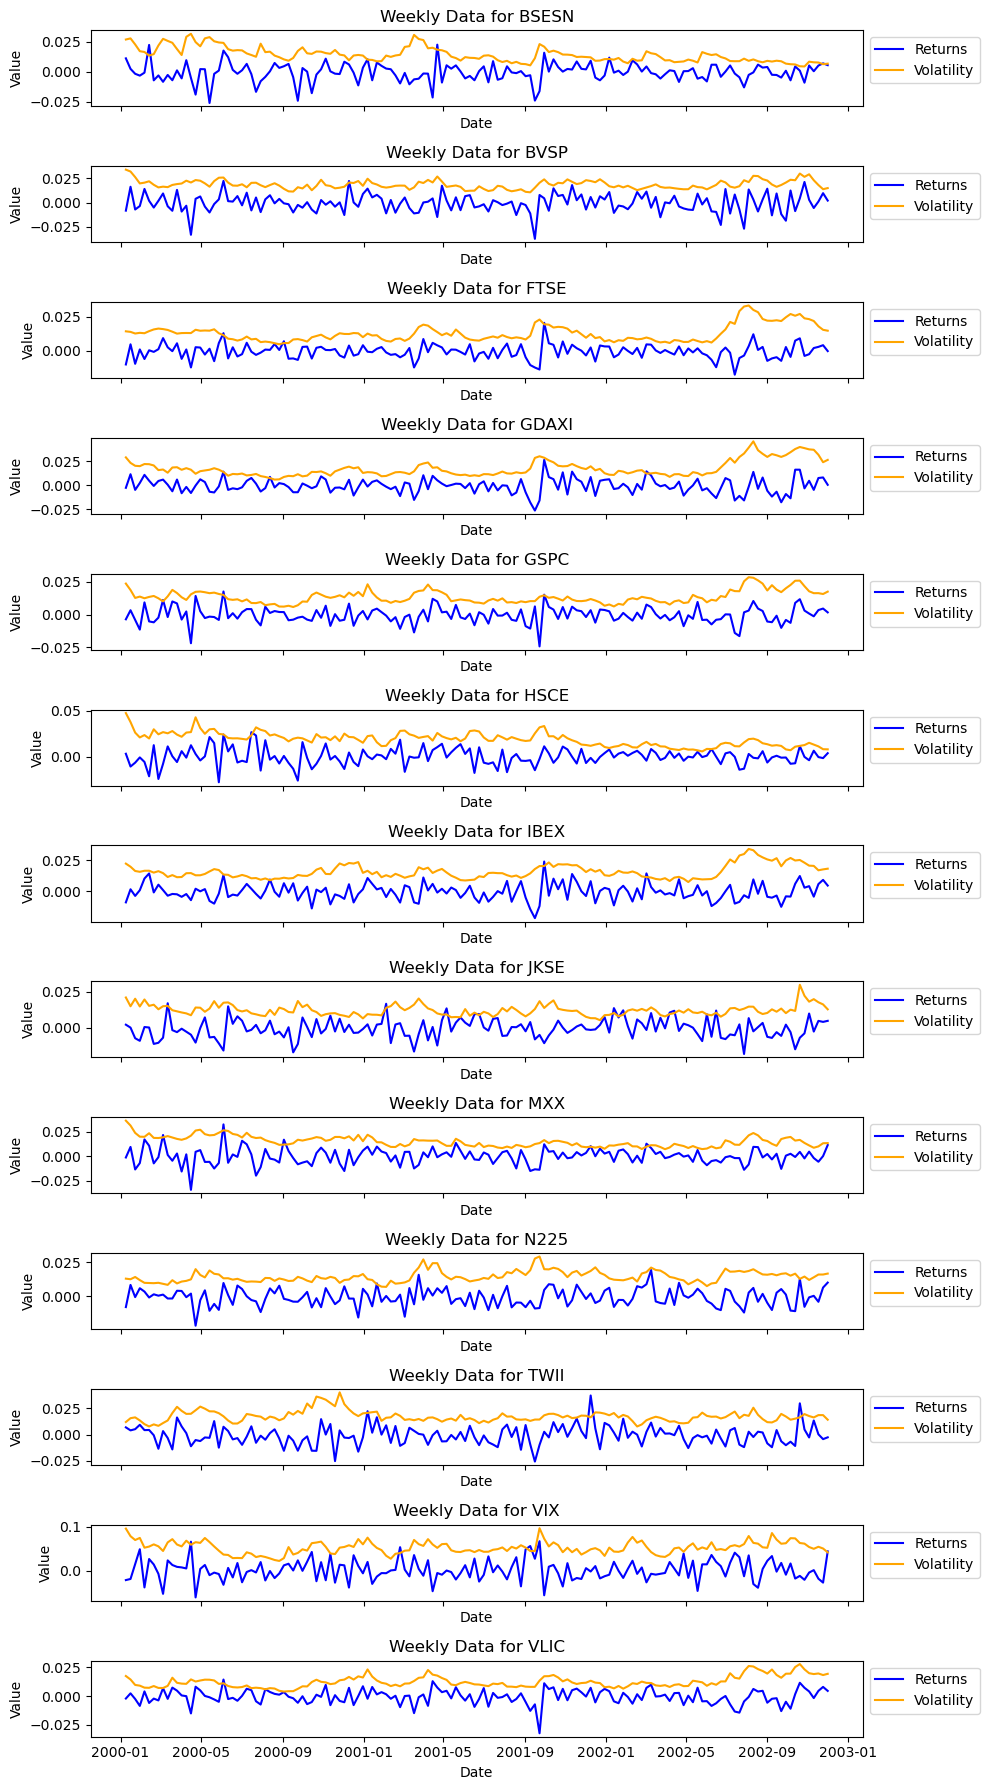

In [854]:
import matplotlib.pyplot as plt

def plot_market_data(df, title_prefix, columns_to_plot):
    # Get unique markets from the DataFrame
    markets = df.index.get_level_values('Market').unique()
    # Determine the number of subplot rows needed (one for each market)
    nrows = len(markets)
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 18), sharex=True)
    
    # Loop over each market and plot the data
    for i, market in enumerate(markets):
        market_data = df.xs(market, level='Market')
        axes[i].plot(market_data.index, market_data[columns_to_plot[0]], color='blue', label='Returns')
        axes[i].plot(market_data.index, market_data[columns_to_plot[1]], color='orange', label='Volatility')
        axes[i].set_title(f"Weekly Data for {market}")
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Columns to plot for weekly data
weekly_columns = ['Returns_Mean_Weekly', 'EMA_Weekly_Volatility']

# Plot weekly data
plot_market_data(weekly_df, "Weekly Data for", weekly_columns)


In [855]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def perform_adf_test(df, columns_to_plot):
    # Prepare dictionary to store results
    adf_results = {}
    markets = df.index.get_level_values('Market').unique()

    for market in markets:
        market_data = df.xs(market, level='Market')
        adf_results[market] = {}

        for column in columns_to_plot:
            # Initial ADF test
            test_result = adfuller(market_data[column])
            adf_results[market][column] = {
                'ADF Statistic': test_result[0],
                'p-value': test_result[1],
                'Critical Values': test_result[4],
                'Stationary': test_result[1] < 0.05
            }
            
            # Print initial stationarity results
            if test_result[1] >= 0.05:
                print(f"Initial non-stationary result for Market: {market}, Column: {column}")
                print(f"  ADF Statistic: {test_result[0]}, p-value: {test_result[1]}")
                
                # If not stationary, differentiate and test again
                differenced_series = market_data[column].diff().dropna()
                if not differenced_series.empty:
                    diff_test_result = adfuller(differenced_series)
                    if diff_test_result[1] < 0.05:
                        # Update results for differenced series
                        adf_results[market][column] = {
                            'ADF Statistic': diff_test_result[0],
                            'p-value': diff_test_result[1],
                            'Critical Values': diff_test_result[4],
                            'Stationary': diff_test_result[1] < 0.05
                        }
                        # Update DataFrame directly in a safe way
                        update_series = pd.Series(differenced_series, name=column, index=pd.MultiIndex.from_product([[market], differenced_series.index]))
                        df.update(update_series)

                        # Print results after differencing
                        print(f"Re-tested stationary result for Market: {market}, Column: {column} after differencing")
                        print(f"  ADF Statistic: {diff_test_result[0]}, p-value: {diff_test_result[1]}")
            else:
                print(f"Market: {market}, Column: {column} is initially stationary.")
    
    return adf_results, df

# Usage
weekly_columns = ['Returns_Mean_Weekly', 'EMA_Weekly_Volatility']
adf_results, weekly_df = perform_adf_test(weekly_df, weekly_columns)




Market: BSESN, Column: Returns_Mean_Weekly is initially stationary.
Market: BSESN, Column: EMA_Weekly_Volatility is initially stationary.
Market: BVSP, Column: Returns_Mean_Weekly is initially stationary.
Market: BVSP, Column: EMA_Weekly_Volatility is initially stationary.
Market: FTSE, Column: Returns_Mean_Weekly is initially stationary.
Market: FTSE, Column: EMA_Weekly_Volatility is initially stationary.
Market: GDAXI, Column: Returns_Mean_Weekly is initially stationary.
Initial non-stationary result for Market: GDAXI, Column: EMA_Weekly_Volatility
  ADF Statistic: -2.4023239062266213, p-value: 0.14108157735014476
Re-tested stationary result for Market: GDAXI, Column: EMA_Weekly_Volatility after differencing
  ADF Statistic: -10.848027759457786, p-value: 1.5543220504851674e-19
Market: GSPC, Column: Returns_Mean_Weekly is initially stationary.
Market: GSPC, Column: EMA_Weekly_Volatility is initially stationary.
Market: HSCE, Column: Returns_Mean_Weekly is initially stationary.
Initial

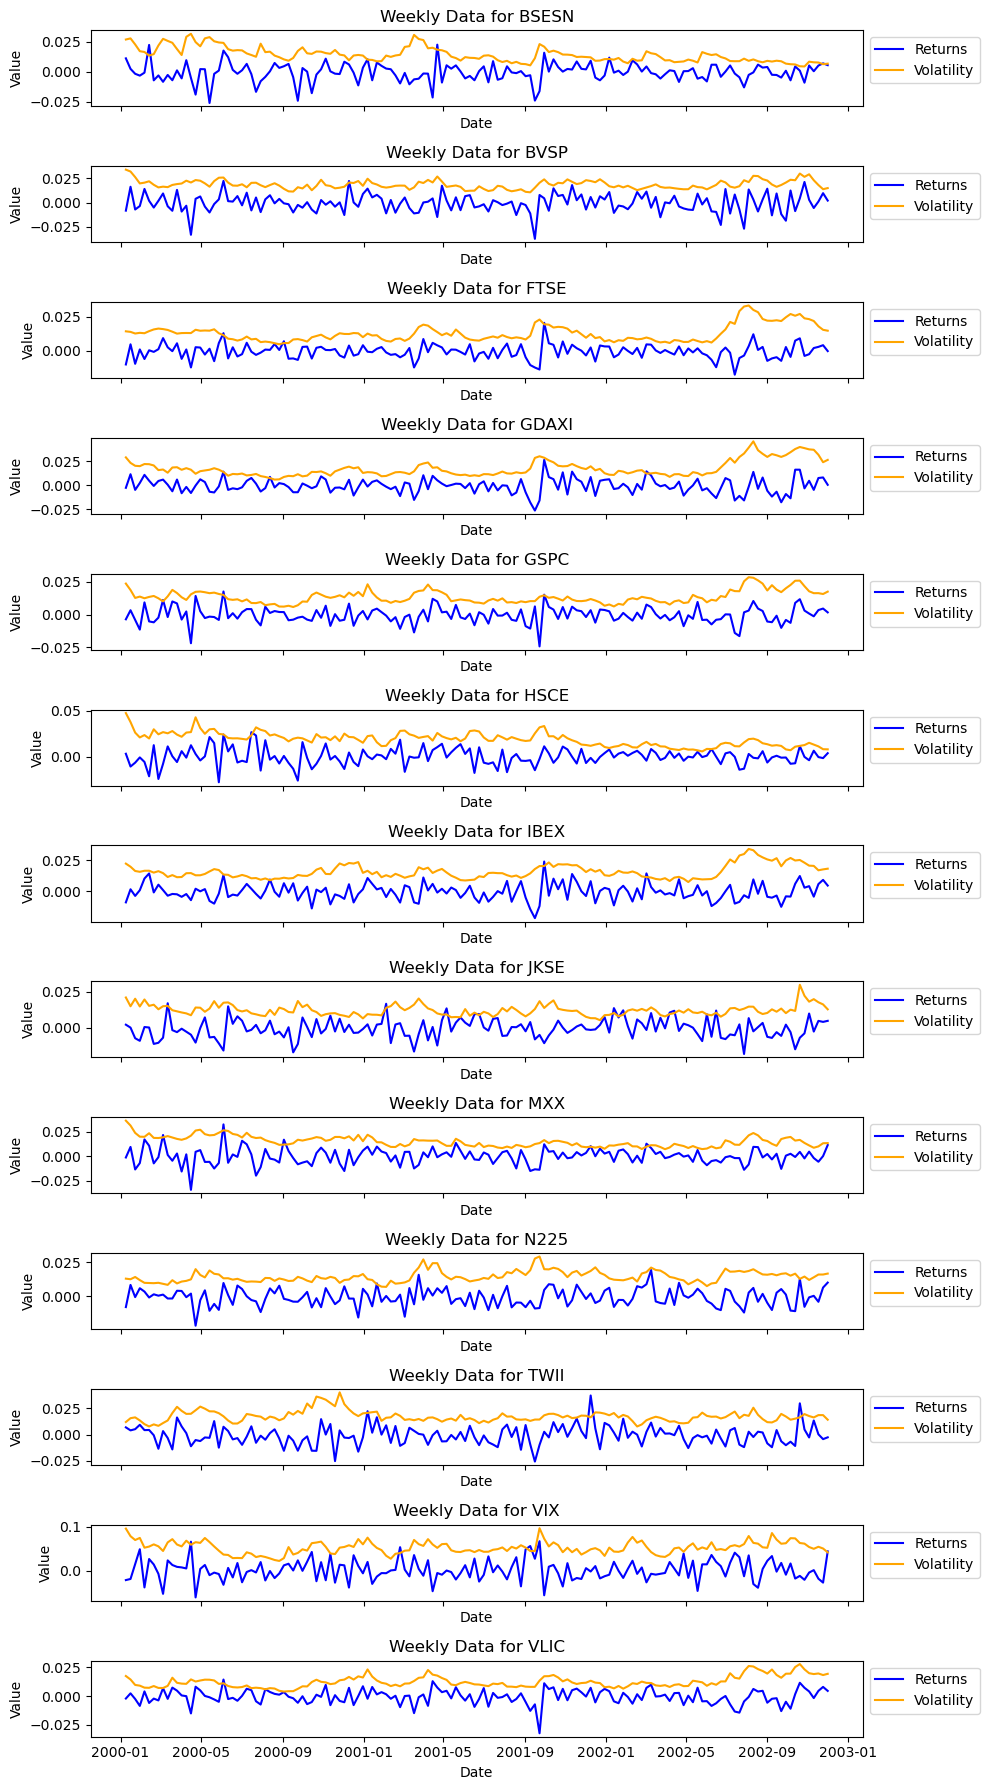

In [856]:

# Plot weekly data
plot_market_data(weekly_df, "Weekly Data for", weekly_columns)

# Monthly Stationarity 

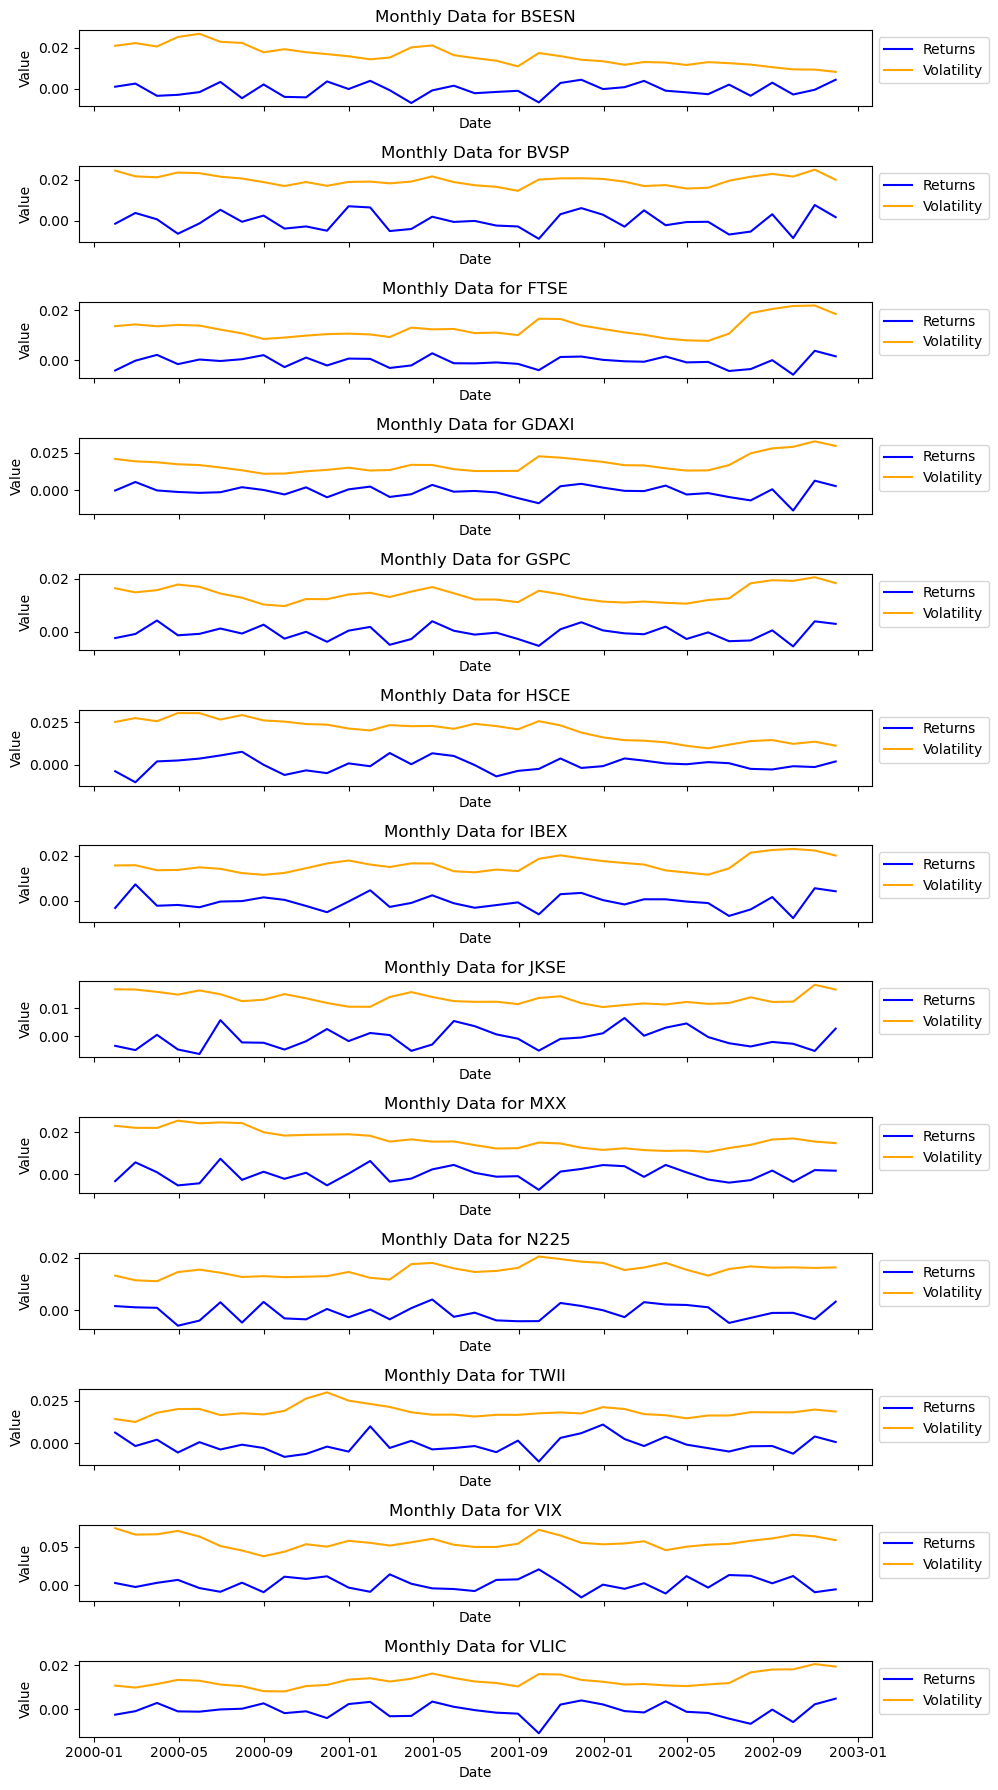

In [857]:
import matplotlib.pyplot as plt

def plot_market_data(df, title_prefix, columns_to_plot):
    # Get unique markets from the DataFrame
    markets = df.index.get_level_values('Market').unique()
    # Determine the number of subplot rows needed (one for each market)
    nrows = len(markets)
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 18), sharex=True)
    
    # Loop over each market and plot the data
    for i, market in enumerate(markets):
        market_data = df.xs(market, level='Market')
        axes[i].plot(market_data.index, market_data[columns_to_plot[0]], color='blue', label='Returns')
        axes[i].plot(market_data.index, market_data[columns_to_plot[1]], color='orange', label='Volatility')
        axes[i].set_title(f"Monthly Data for {market}")
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')

        # Place the legend outside the plot on the right
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# Columns to plot for monthly data
monthly_columns = ['Returns_Mean_Monthly', 'EMA_Monthly_Volatility']

# Plot monthly data
plot_market_data(monthly_df, "Monthly Data for", monthly_columns)

In [858]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def perform_adf_test_monthly(df, columns_to_plot):
    # Prepare dictionary to store results
    adf_results = {}
    markets = df.index.get_level_values('Market').unique()

    for market in markets:
        market_data = df.xs(market, level='Market')
        adf_results[market] = {}

        for column in columns_to_plot:
            # Initial ADF test
            test_result = adfuller(market_data[column])
            adf_results[market][column] = {
                'ADF Statistic': test_result[0],
                'p-value': test_result[1],
                'Critical Values': test_result[4],
                'Stationary': test_result[1] < 0.05
            }
            
            # Print initial stationarity results
            if test_result[1] >= 0.05:
                print(f"Initial non-stationary result for Market: {market}, Column: {column}")
                print(f"  ADF Statistic: {test_result[0]}, p-value: {test_result[1]}")
                
                # If not stationary, differentiate and test again
                differenced_series = market_data[column].diff().dropna()
                if not differenced_series.empty:
                    diff_test_result = adfuller(differenced_series)
                    if diff_test_result[1] < 0.05:
                        # Update results for differenced series
                        adf_results[market][column] = {
                            'ADF Statistic': diff_test_result[0],
                            'p-value': diff_test_result[1],
                            'Critical Values': diff_test_result[4],
                            'Stationary': diff_test_result[1] < 0.05
                        }
                        # Update DataFrame directly in a safe way
                        update_series = pd.Series(differenced_series, name=column, index=pd.MultiIndex.from_product([[market], differenced_series.index]))
                        df.update(update_series)

                        # Print results after differencing
                        print(f"Re-tested stationary result for Market: {market}, Column: {column} after differencing")
                        print(f"  ADF Statistic: {diff_test_result[0]}, p-value: {diff_test_result[1]}")
            else:
                print(f"Market: {market}, Column: {column} is initially stationary.")
    
    return adf_results, df

# Usage: Assuming you have monthly columns similar to the weekly ones
monthly_columns = ['Returns_Mean_Monthly', 'EMA_Monthly_Volatility']
adf_results_monthly, monthly_df = perform_adf_test_monthly(monthly_df, monthly_columns)


Market: BSESN, Column: Returns_Mean_Monthly is initially stationary.
Initial non-stationary result for Market: BSESN, Column: EMA_Monthly_Volatility
  ADF Statistic: -1.368236655397091, p-value: 0.5974056222989383
Re-tested stationary result for Market: BSESN, Column: EMA_Monthly_Volatility after differencing
  ADF Statistic: -6.106507618786912, p-value: 9.556212811293664e-08
Market: BVSP, Column: Returns_Mean_Monthly is initially stationary.
Market: BVSP, Column: EMA_Monthly_Volatility is initially stationary.
Market: FTSE, Column: Returns_Mean_Monthly is initially stationary.
Initial non-stationary result for Market: FTSE, Column: EMA_Monthly_Volatility
  ADF Statistic: -2.4692747323250557, p-value: 0.12313019167531053
Market: GDAXI, Column: Returns_Mean_Monthly is initially stationary.
Initial non-stationary result for Market: GDAXI, Column: EMA_Monthly_Volatility
  ADF Statistic: -1.6722031629212681, p-value: 0.4454881302936885
Re-tested stationary result for Market: GDAXI, Column:

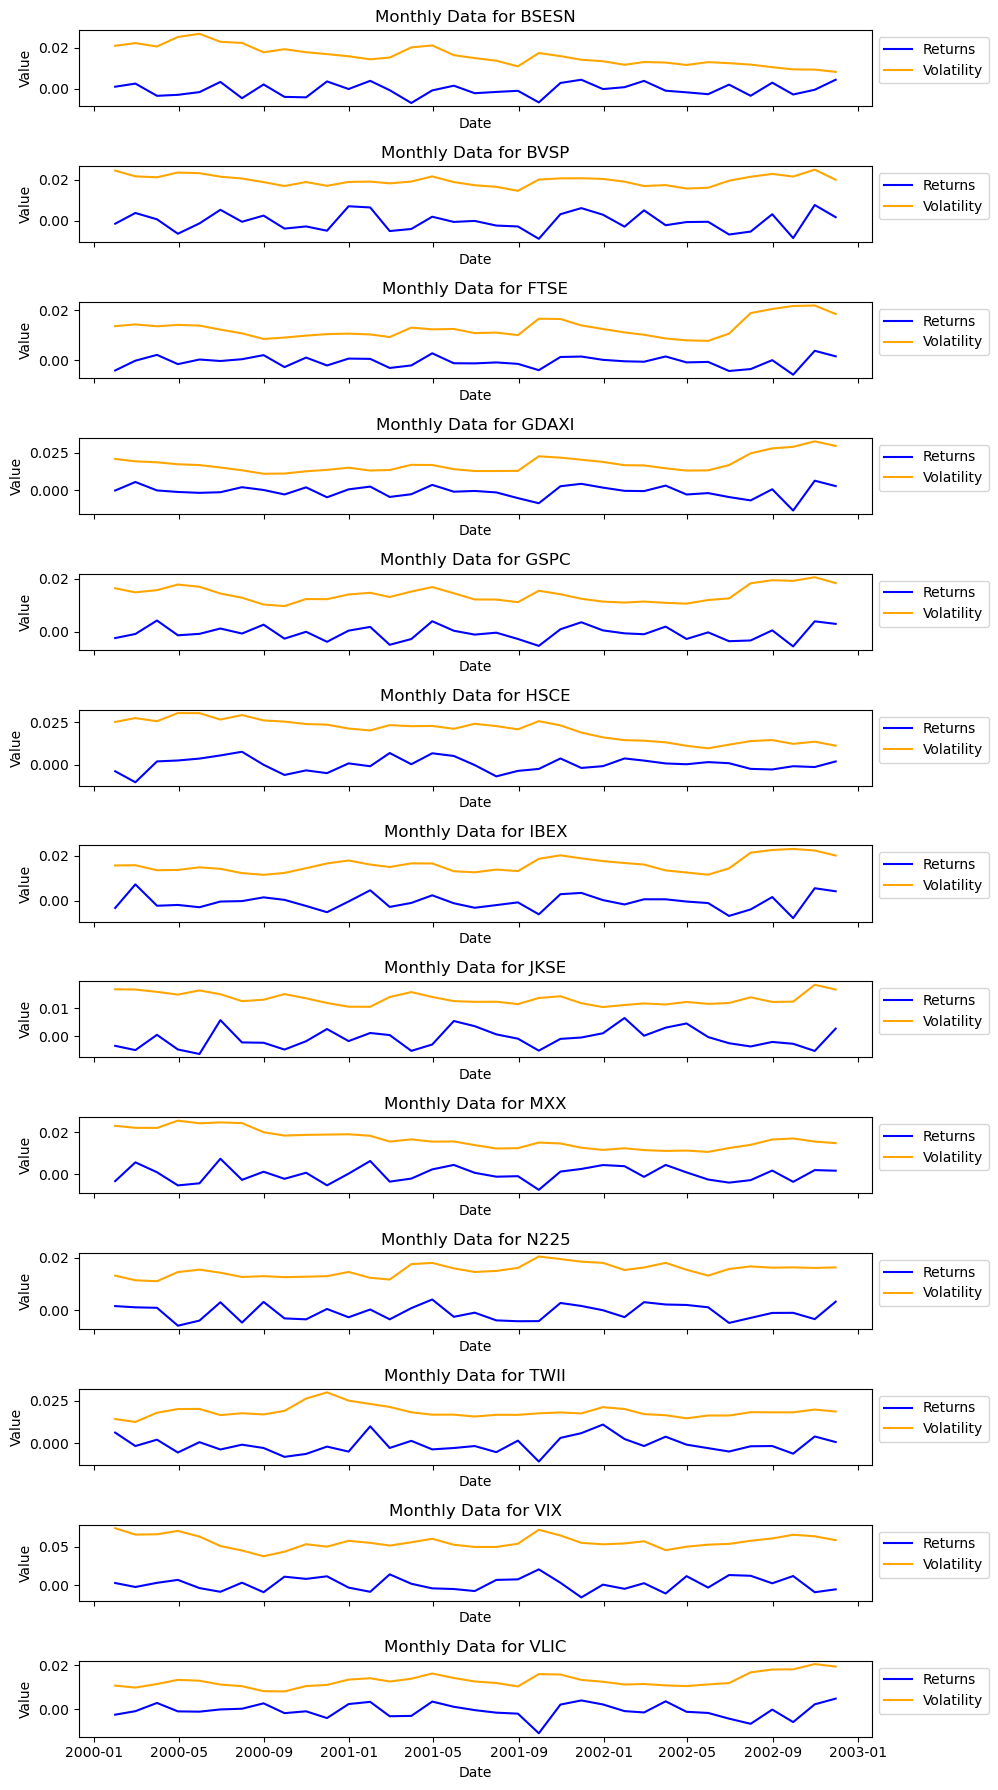

In [859]:
# Plot monthly data
plot_market_data(monthly_df, "Monthly Data for", monthly_columns)

# 4. CAUSALITY ANALYSIS

In [860]:
weekly_df

Open first     High max      Low min   Close last  \
Market Date                                                             
BSESN  2000-01-09  7814.310059  8300.969970  7776.719970  8121.719970   
       2000-01-16  8426.384766  8502.419678  7831.919678  8206.905030   
       2000-01-23  8426.550293  8496.750000  7995.120117  8134.574707   
       2000-01-30  8294.069824  8374.830322  7997.310059  8003.699707   
       2000-02-06  8008.004883  8104.050293  7691.685059  7970.384766   
...                        ...          ...          ...          ...   
VLIC   2002-11-03   385.814987   393.509994   373.530006   393.509994   
       2002-11-10   393.509994   405.644990   389.009994   389.865006   
       2002-11-17   389.865006   398.789977   379.290002   398.445007   
       2002-11-24   398.445007   416.279984   392.070007   414.390015   
       2002-12-01   414.390015   424.890015   410.384994   421.634994   

                   Volume mean  Adj Close last  Returns Last  \
Market Date                                                    
BSESN  2000-01-09          0.0     8121.719970     -0.001300   
       2000-01-16          0.0     8206.905030      0.004858   
       2000-01-23          0.0     8134.574707      0.012556   
       2000-01-30          0.0     8003.699707     -0.006202   
       2000-02-06          0.0     7970.384766     -0.004981   
...                        ...             ...           ...   
VLIC   2002-11-03   14511000.0      393.509994      0.025006   
       2002-11-10   14289000.0      389.865006     -0.014447   
       2002-11-17   14202000.0      398.445007      0.005527   
       2002-11-24   21141000.0      414.390015      0.004107   
       2002-12-01   18176250.0      421.634994     -0.003969   

                   Returns Volatility  Returns_Mean_Weekly  \
Market Date                                                  
BSESN  2000-01-09            0.026863             0.011181   
       2000-01-16            0.029187             0.002431   
       2000-01-23            0.015210            -0.001676   
       2000-01-30            0.008693            -0.003208   
       2000-02-06            0.015509            -0.000737   
...                               ...                  ...   
VLIC   2002-11-03            0.014885             0.004045   
       2002-11-10            0.018049            -0.001729   
       2002-11-17            0.020451             0.004531   
       2002-11-24            0.016238             0.007983   
       2002-12-01            0.021006             0.004507   

                   EMA_Weekly_Volatility  
Market Date                               
BSESN  2000-01-09               0.026863  
       2000-01-16               0.027792  
       2000-01-23               0.022760  
       2000-01-30               0.017133  
       2000-02-06               0.016483  
...                                  ...  
VLIC   2002-11-03               0.019902  
       2002-11-10               0.019161  
       2002-11-17               0.019677  
       2002-11-24               0.018301  
       2002-12-01               0.019383  

[1976 rows x 10 columns]

In [861]:
monthly_df

Open first     High max      Low min   Close last  \
Market Date                                                             
BSESN  2000-01-31  7814.310059  8502.419678  7776.719970  7807.935059   
       2000-02-29  7826.474853  9226.034911  7691.685059  8171.205322   
       2000-03-31  8196.974853  8743.185059  7300.844970  7501.919678   
       2000-04-30  7605.750000  8314.215089  6426.254883  6986.324707   
       2000-05-31  7135.900147  7136.835206  5747.790160  6650.414794   
...                        ...          ...          ...          ...   
VLIC   2002-07-31   486.464997   486.464997   373.860007   417.449982   
       2002-08-31   417.449982   437.880020   384.480010   414.195007   
       2002-09-30   414.195007   418.380020   359.474991   366.974991   
       2002-10-31   366.974991   389.490006   326.519990   383.910003   
       2002-11-30   383.910003   424.890015   379.290002   421.634994   

                    Volume mean  Adj Close last  Returns Last  \
Market Date                                                     
BSESN  2000-01-31  0.000000e+00     7807.935059     -0.024459   
       2000-02-29  0.000000e+00     8171.205322     -0.051077   
       2000-03-31  0.000000e+00     7501.919678     -0.007895   
       2000-04-30  0.000000e+00     6986.324707     -0.004718   
       2000-05-31  0.000000e+00     6650.414794      0.028258   
...                         ...             ...           ...   
VLIC   2002-07-31  1.606364e+07      417.449982     -0.011649   
       2002-08-31  1.228295e+07      414.195007     -0.004471   
       2002-09-30  1.214100e+07      366.974991     -0.008872   
       2002-10-31  1.516043e+07      383.910003     -0.000625   
       2002-11-30  1.680150e+07      421.634994     -0.003969   

                   Returns Volatility  Returns_Mean_Monthly  \
Market Date                                                   
BSESN  2000-01-31            0.021003              0.000913   
       2000-02-29            0.024254              0.002451   
       2000-03-31            0.018175             -0.003550   
       2000-04-30            0.032307             -0.003057   
       2000-05-31            0.029217             -0.001730   
...                               ...                   ...   
VLIC   2002-07-31            0.024207             -0.006662   
       2002-08-31            0.020103             -0.000163   
       2002-09-30            0.018351             -0.005873   
       2002-10-31            0.024246              0.002244   
       2002-11-30            0.017811              0.004848   

                   EMA_Monthly_Volatility  
Market Date                                
BSESN  2000-01-31                0.021003  
       2000-02-29                0.022303  
       2000-03-31                0.020652  
       2000-04-30                0.025314  
       2000-05-31                0.026875  
...                                   ...  
VLIC   2002-07-31                0.016853  
       2002-08-31                0.018153  
       2002-09-30                0.018232  
       2002-10-31                0.020638  
       2002-11-30                0.019507  

[455 rows x 10 columns]

## 4.1 Weekly Causality

In [862]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming 'weekly_df' is your DataFrame with 'Market' as part of a MultiIndex

# Get unique markets
markets = weekly_df.index.get_level_values('Market').unique()

# Initialize matrices to store results
weekly_results_returns = pd.DataFrame(index=markets, columns=markets, dtype=object)
weekly_results_volatility = pd.DataFrame(index=markets, columns=markets, dtype=object)

# Function to perform Granger Causality for each lag and return results
def test_granger(dataframe, maxlag):
    test_result = grangercausalitytests(dataframe, maxlag=maxlag)
    # Collect the p-values for each lag in a tuple
    results = tuple(1 if test_result[lag][0]['ssr_chi2test'][1] < 0.05 else 0 for lag in range(1, maxlag + 1))
    return results

# Loop over each pair of markets
for market1 in markets:
    for market2 in markets:
        if market1 != market2:
            # Prepare data for each market pair
            data1 = weekly_df.xs(market1, level='Market')['Returns_Mean_Weekly']
            data2 = weekly_df.xs(market2, level='Market')['Returns_Mean_Weekly']
            merged_returns = pd.concat([data1, data2], axis=1).dropna()

            data1_vol = weekly_df.xs(market1, level='Market')['EMA_Weekly_Volatility']
            data2_vol = weekly_df.xs(market2, level='Market')['EMA_Weekly_Volatility']
            merged_volatility = pd.concat([data1_vol, data2_vol], axis=1).dropna()

            # Granger Causality Test for Returns Mean Weekly
            if not merged_returns.empty:
                weekly_results_returns.at[market1, market2] = test_granger(merged_returns, maxlag=4)

            # Granger Causality Test for EMA Weekly Volatility
            if not merged_volatility.empty:
                weekly_results_volatility.at[market1, market2] = test_granger(merged_volatility, maxlag=4)

# Fill diagonal where market comparison would be self to self (i.e., no test applicable)
for market in markets:
    weekly_results_returns.at[market, market] = ("-")
    weekly_results_volatility.at[market, market] = ("-")





Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1911 , p=0.0002  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=14.4788 , p=0.0001  , df=1
likelihood ratio test: chi2=13.8261 , p=0.0002  , df=1
parameter F test:         F=14.1911 , p=0.0002  , df_denom=148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5736  , p=0.0007  , df_denom=145, df_num=2
ssr based chi2 test:   chi2=15.6696 , p=0.0004  , df=2
likelihood ratio test: chi2=14.9040 , p=0.0006  , df=2
parameter F test:         F=7.5736  , p=0.0007  , df_denom=145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3295  , p=0.0017  , df_denom=142, df_num=3
ssr based chi2 test:   chi2=16.7766 , p=0.0008  , df=3
likelihood ratio test: chi2=15.8975 , p=0.0012  , df=3
parameter F test:         F=5.3295  , p=0.0017  , df_denom=142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0298  , p=0.0008  

In [863]:
# Display the result matrices
weekly_results_returns.index.name = None
print("Granger Causality Results for Returns Mean Weekly:")
weekly_results_returns


Granger Causality Results for Returns Mean Weekly:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (1, 1, 1, 1)  (1, 1, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)   
BVSP   (0, 0, 0, 0)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 1, 0, 0)  (0, 0, 0, 0)             -  (0, 1, 0, 1)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 0)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 0, 0, 0)  (0, 1, 1, 1)   
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 1, 1, 1)  (0, 0, 1, 1)  (1, 1, 1, 1)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
TWII   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 0)   
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (1, 0, 0, 0)  (0, 0, 0, 0)             -  (1, 1, 1, 1)  (0, 0, 0, 0)   
MXX    (1, 1, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 0, 0, 0)             -   
TWII   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 0)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GDAXI  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GSPC   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
TWII              -  (1, 1, 1, 1)  (1, 1, 1, 1)  
VIX    (0, 0, 0, 0)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)             -

In [864]:
# Display the result matrices
weekly_results_volatility.index.name = None

print("\nGranger Causality Results for EMA Weekly Volatility:")
weekly_results_volatility



Granger Causality Results for EMA Weekly Volatility:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (0, 0, 0, 0)  (0, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)             -  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)   
FTSE   (0, 0, 0, 0)  (1, 1, 1, 1)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 1)  (1, 1, 0, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)             -   
HSCE   (1, 1, 0, 0)  (1, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 1, 1, 0)  (0, 1, 1, 0)   
TWII   (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 1, 1, 0)  (0, 1, 1, 1)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 1)  (0, 0, 1, 1)  (1, 1, 1, 1)  (1, 1, 1, 1)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (1, 1, 1, 0)  (0, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 1, 1, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)   
GDAXI  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 1)   
GSPC   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 1)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 0)             -   
TWII   (0, 1, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 0, 0, 0)   
VIX    (0, 0, 0, 0)  (1, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 0)   
VLIC   (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 1)  (1, 1, 1, 1)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 0, 1, 0)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
TWII              -  (0, 0, 0, 0)  (0, 1, 1, 1)  
VIX    (0, 0, 0, 0)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)             -

## 4.2 Monthly Causality

In [865]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming 'monthly_df' is your DataFrame with 'Market' as part of a MultiIndex

# Get unique markets
markets = monthly_df.index.get_level_values('Market').unique()

# Initialize matrices to store results
monthly_results_returns = pd.DataFrame(index=markets, columns=markets, dtype=object)
monthly_results_volatility = pd.DataFrame(index=markets, columns=markets, dtype=object)

# Function to perform Granger Causality for each lag and return results
def test_granger(dataframe, maxlag):
    test_result = grangercausalitytests(dataframe, maxlag=maxlag)
    # Collect the p-values for each lag in a tuple
    results = tuple(1 if test_result[lag][0]['ssr_chi2test'][1] < 0.05 else 0 for lag in range(1, maxlag + 1))
    return results

# Loop over each pair of markets
for market1 in markets:
    for market2 in markets:
        if market1 != market2:
            # Prepare data for each market pair
            data1 = monthly_df.xs(market1, level='Market')['Returns_Mean_Monthly']  # Update column names if different
            data2 = monthly_df.xs(market2, level='Market')['Returns_Mean_Monthly']
            merged_returns = pd.concat([data1, data2], axis=1).dropna()

            data1_vol = monthly_df.xs(market1, level='Market')['EMA_Monthly_Volatility']  # Update column names if different
            data2_vol = monthly_df.xs(market2, level='Market')['EMA_Monthly_Volatility']
            merged_volatility = pd.concat([data1_vol, data2_vol], axis=1).dropna()

            # Granger Causality Test for Returns Mean Monthly
            if not merged_returns.empty:
                monthly_results_returns.at[market1, market2] = test_granger(merged_returns, maxlag=4)

            # Granger Causality Test for EMA Monthly Volatility
            if not merged_volatility.empty:
                monthly_results_volatility.at[market1, market2] = test_granger(merged_volatility, maxlag=4)

# Fill diagonal where market comparison would be self to self (i.e., no test applicable)
for market in markets:
    monthly_results_returns.at[market, market] = ("-")
    monthly_results_volatility.at[market, market] = ("-")



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3372  , p=0.1365  , df_denom=31, df_num=1
ssr based chi2 test:   chi2=2.5634  , p=0.1094  , df=1
likelihood ratio test: chi2=2.4714  , p=0.1159  , df=1
parameter F test:         F=2.3372  , p=0.1365  , df_denom=31, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1222  , p=0.0597  , df_denom=28, df_num=2
ssr based chi2 test:   chi2=7.3595  , p=0.0252  , df=2
likelihood ratio test: chi2=6.6436  , p=0.0361  , df=2
parameter F test:         F=3.1222  , p=0.0597  , df_denom=28, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3940  , p=0.0923  , df_denom=25, df_num=3
ssr based chi2 test:   chi2=9.1929  , p=0.0268  , df=3
likelihood ratio test: chi2=8.0810  , p=0.0444  , df=3
parameter F test:         F=2.3940  , p=0.0923  , df_denom=25, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3748  , p=0.2749  , df_d

In [866]:
# Display the result matrices
monthly_results_returns.index.name = None
print("Granger Causality Results for Returns Mean Monthly:")
monthly_results_returns


Granger Causality Results for Returns Mean Monthly:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (0, 1, 1, 0)  (0, 1, 1, 1)  (0, 1, 1, 0)  (0, 1, 1, 1)   
BVSP   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (1, 1, 0, 0)  (1, 1, 1, 1)  (1, 1, 1, 1)  (1, 0, 1, 1)   
MXX    (0, 1, 1, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 1, 1, 1)  (0, 1, 0, 0)  (0, 1, 1, 1)   
TWII   (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
HSCE              -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
JKSE   (0, 0, 0, 0)  (1, 0, 0, 1)             -  (1, 1, 0, 1)  (0, 0, 0, 0)   
MXX    (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 1)             -  (0, 0, 0, 0)   
N225   (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)             -   
TWII   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (1, 1, 1, 1)  (0, 0, 0, 1)  (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 0)  (0, 1, 1, 1)  (0, 0, 0, 0)  
BVSP   (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (1, 1, 1, 0)  (1, 0, 0, 0)  
MXX    (0, 0, 0, 0)  (1, 1, 1, 1)  (0, 0, 0, 0)  
N225   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
TWII              -  (0, 0, 1, 1)  (0, 0, 0, 1)  
VIX    (0, 0, 0, 1)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 0)             -

In [867]:
monthly_results_volatility.index.name = None
print("\nGranger Causality Results for EMA Monthly Volatility:")
monthly_results_volatility


Granger Causality Results for EMA Monthly Volatility:


BSESN          BVSP          FTSE         GDAXI          GSPC  \
BSESN             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
BVSP   (0, 0, 0, 0)             -  (1, 1, 1, 1)  (0, 1, 0, 0)  (1, 1, 0, 0)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)  (0, 0, 0, 0)   
GDAXI  (1, 1, 1, 1)  (1, 1, 1, 0)  (0, 0, 0, 0)             -  (0, 0, 0, 0)   
GSPC   (0, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)             -   
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
IBEX   (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 0, 0)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
N225   (0, 1, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
TWII   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VIX    (1, 0, 0, 0)  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)   
VLIC   (1, 1, 1, 1)  (0, 0, 0, 0)  (0, 1, 1, 0)  (0, 1, 1, 1)  (0, 0, 0, 1)   

               HSCE          IBEX          JKSE           MXX          N225  \
BSESN  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 1, 0)   
BVSP   (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 1, 0, 1)  (0, 0, 1, 1)   
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)   
GDAXI  (1, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)   
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)   
HSCE              -  (1, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 0)  (1, 1, 1, 0)   
IBEX   (0, 0, 0, 1)             -  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)   
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)             -  (0, 1, 0, 0)  (0, 0, 0, 0)   
MXX    (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)             -  (0, 1, 1, 1)   
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (1, 1, 0, 0)             -   
TWII   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 1, 1)  (0, 0, 0, 0)   
VIX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 0)   
VLIC   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 1)  (0, 0, 0, 1)   

               TWII           VIX          VLIC  
BSESN  (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
BVSP   (0, 0, 0, 0)  (1, 1, 1, 0)  (0, 0, 0, 0)  
FTSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
GDAXI  (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 1, 1, 1)  
GSPC   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
HSCE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
IBEX   (0, 0, 0, 1)  (0, 0, 0, 0)  (0, 0, 0, 0)  
JKSE   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
MXX    (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
N225   (0, 0, 0, 0)  (0, 0, 0, 0)  (0, 0, 0, 0)  
TWII              -  (0, 0, 1, 1)  (0, 0, 0, 1)  
VIX    (0, 0, 0, 0)             -  (0, 0, 0, 0)  
VLIC   (0, 0, 0, 0)  (0, 0, 0, 1)             -